<a href="https://colab.research.google.com/github/travislatchman/Malignant-Lymphoma-Classification/blob/main/CNN_TransferLearning_Lymphoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

we will learn to classify three types of malignant lymphoma by:

- training Convolutional Neural Network (CNN)
- doing transfer learning using pre-trained models, fine-tuning, and re-training the last layers.



We will be using the [Malignant Lymphoma Classification](https://www.kaggle.com/datasets/andrewmvd/malignant-lymphoma-classification?resource=download) provided in kaggle. For details about the dataset, please read the [documentation](https://www.kaggle.com/datasets/andrewmvd/malignant-lymphoma-classification?resource=download) or the [paper](https://ieeexplore.ieee.org/abstract/document/5505922): *Orlov, Nikita V., et al. "Automatic classification of lymphoma images with transform-based global features." IEEE Transactions on Information Technology in Biomedicine 14.4 (2010): 1003-1013.*


<br> For a short summary:
Malignant lymphoma is a cancer affecting lymph nodes.
Three types of malignant lymphoma are represented in the dataset:

CLL (chronic lymphocytic leukemia);

FL (follicular lymphoma);

MCL (mantle cell lymphoma).

Download all the files and upload all the three folders CLL, FL, MCL to somewhere in your Google Drive. For example, \content\drive\Lymphoma\\

Please always emember to use the MLMA coding rubric.


## Library imports


In [ ]:
# Please be free to add more libraries if needed
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # additional plotting functionality
from sklearn.model_selection import train_test_split # Train test split
import torch # torch
from torchvision import transforms # transform is used for data pre-processing
from torch.utils import data as Data
from torch.utils.data import Dataset # for dataset construction
import torch.optim as optim
from PIL import Image
import numpy as np
import imageio
import cv2 as cv # cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import random # For randomizing
from collections import Counter
import re
import os
import cv2

# Part I
Read the dataset and apply essential pre-processing steps.

### Task 1:
Read the data and construct the labels

In [ ]:
# load your drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
lymphoma_path = '/content/drive/MyDrive/Colab Notebooks/Lymphoma'


In [ ]:
CLL_path = '/content/drive/Lymphoma/CLL'
FL_path = '/content/drive/MyDrive/Colab Notebooks/Lymphoma/FL'
MCL_path = '/content/drive/MyDrive/Colab Notebooks/Lymphoma/MCL'


In [ ]:
# Read the images from the data path, construct numpy arrays for data and label
def Read_Image_And_Label(Data_Path, Label_Names):
  """
Read the images from the data path, when images of different classes are seperatedly stored in different folders named with their label names;
construct numpy arrays for both the image data and the image labels.

You could resize the images if you think they are too large.
Inputs:
      Data_Path: the path of the data, in our case is the parent derectory of the three folders CLL, FL, and MCL.
      Label_Names: the class names, in our case are the names of three subfolders.
Outputs:
      Image_Array: numpy array storing the images, please read the images in grayscale rather than RGB. C*M*N, C images and each image is
        of the size M*N
      Label_Array: numpy array storing the labels. C*1, C images and each with one label
        And lets redefine the labels as index:
              Label CLL: 1
              Label FL: 2
              Label MCL: 3
      Patient_Index: numpy array storing patients's indexs. You could tell it from the file naming, like sj-05-6124-R4_016 is for patient 6124.
  """




In [ ]:
def Read_Image_And_Label(Data_Path, Label_Names):
    Image_Array = []
    Label_Array = []
    Patient_Index = []
    label_mapping = {"CLL": 1, "FL": 2, "MCL": 3}

    for label in Label_Names:
        class_path = os.path.join(Data_Path, label)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Read image in grayscale
            resized_img = cv2.resize(img, (128, 128)) # Resize image if necessary
            Image_Array.append(resized_img)
            Label_Array.append(label_mapping[label])
            patient_id = img_name.split("-")[2].split('_')[0]
            Patient_Index.append(int(patient_id))

    # Convert lists to numpy arrays
    Image_Array = np.array(Image_Array)
    Label_Array = np.array(Label_Array).reshape(-1, 1)
    Patient_Index = np.array(Patient_Index).reshape(-1, 1)

    return Image_Array, Label_Array, Patient_Index

In [ ]:
Data_Path  = '/content/drive/MyDrive/Colab Notebooks/Lymphoma'; #replace with your path
Label_Names = ['CLL', 'FL', 'MCL']
Image_Array, Label_Array,Patient_Index   = Read_Image_And_Label(Data_Path, Label_Names)


In [ ]:
Patient_Index_Count = dict(Counter(Patient_Index.flatten()))
Label_Array_Count  = dict(Counter(Label_Array.flatten()))

In [ ]:
Patient_Index_Count

{2810: 11,
 476: 10,
 4957: 10,
 5521: 10,
 852: 14,
 1396: 11,
 3165: 12,
 3344: 11,
 3874: 10,
 5269: 14,
 1467: 11,
 1881: 19,
 4881: 10,
 5311: 13,
 5389: 19,
 5829: 12,
 588: 10,
 6124: 31,
 894: 14,
 3077: 11,
 4525: 12,
 4967: 11,
 6010: 11,
 1374: 14,
 3362: 15,
 4179: 11,
 5326: 12,
 768: 15,
 901: 10}

In [ ]:
len(Patient_Index_Count)

29

In [ ]:
Label_Array_Count

{1: 113, 2: 139, 3: 122}

In [ ]:
len(Label_Array_Count)

3

In [ ]:
Image_Array

array([[[125,  74,  71, ..., 123, 114, 140],
        [119, 126, 145, ..., 160,  95, 100],
        [ 90, 105, 140, ..., 132,  93, 137],
        ...,
        [ 75, 125, 152, ...,  95, 131,  82],
        [140,  89,  82, ..., 149, 156,  90],
        [143, 129, 129, ...,  74, 134, 108]],

       [[ 66, 105, 138, ...,  57,  71,  93],
        [ 58, 139,  97, ..., 108,  75, 137],
        [111,  88,  95, ...,  73,  92, 146],
        ...,
        [ 90,  97, 112, ...,  64, 140,  73],
        [136, 132, 187, ..., 110, 105,  76],
        [121, 127, 116, ..., 147,  88, 128]],

       [[ 98, 132,  66, ...,  79, 176,  76],
        [ 84, 132,  89, ...,  56, 115, 152],
        [117,  90,  70, ..., 135, 156,  89],
        ...,
        [131, 123,  91, ..., 109, 144,  88],
        [113, 126, 160, ..., 153, 122, 142],
        [110, 128, 190, ..., 151,  91, 133]],

       ...,

       [[108, 100,  98, ...,  97,  61, 113],
        [ 83,  99, 126, ...,  66,  83,  85],
        [ 74,  95,  98, ..., 108, 136,  67

In [ ]:
Image_Array.shape

(374, 128, 128)

In [ ]:
Image_Array[1].shape

(128, 128)

### Task 2 :  
Split into train-validation-test set and data visualization, and avoid that imgaes from a same person appear simutaneously in training and testing set.

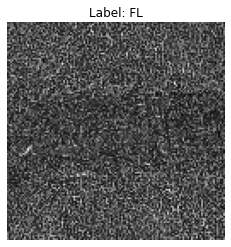

In [ ]:

# Select a random image index
image_index = random.randint(0, len(Image_Array) - 1)

# Get the image and its corresponding label
image = Image_Array[image_index]
label = Label_Array[image_index]

# Define a mapping from label indices to names
label_mapping = {1: "CLL", 2: "FL", 3: "MCL"}

# Plot the image with its label
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label_mapping[label[0]]}")
plt.axis("off")
plt.show()


In [ ]:
def split_data_by_patient(Image_Array, Label_Array, Patient_Index, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    unique_patients = np.unique(Patient_Index)
    random.shuffle(unique_patients)

    train_count = int(len(unique_patients) * train_ratio)
    val_count = int(len(unique_patients) * val_ratio)

    train_patients = unique_patients[:train_count]
    val_patients = unique_patients[train_count:train_count + val_count]
    test_patients = unique_patients[train_count + val_count:]

    train_indices = np.isin(Patient_Index, train_patients)
    val_indices = np.isin(Patient_Index, val_patients)
    test_indices = np.isin(Patient_Index, test_patients)

    X_train, y_train = Image_Array[train_indices.flatten()], Label_Array[train_indices.flatten()]
    X_val, y_val = Image_Array[val_indices.flatten()], Label_Array[val_indices.flatten()]
    X_test, y_test = Image_Array[test_indices.flatten()], Label_Array[test_indices.flatten()]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
# Split the data into train-validation
X_train, y_train, X_val, y_val, X_test, y_test = split_data_by_patient(Image_Array, Label_Array, Patient_Index)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Train set size: 268
Validation set size: 50
Test set size: 56


In [ ]:

Val_patient = [4957,5311,4967];
Test_patient = [2810,476,1467,4881,3077,4525];



In [ ]:
def split_data_by_patient_predefined(Image_Array, Label_Array, Patient_Index, Val_patient, Test_patient):
    unique_patients = np.unique(Patient_Index)

    val_patients = np.array(Val_patient)
    test_patients = np.array(Test_patient)
    train_patients = np.array(list(set(unique_patients) - set(val_patients) - set(test_patients)))

    train_indices = np.isin(Patient_Index, train_patients)
    val_indices = np.isin(Patient_Index, val_patients)
    test_indices = np.isin(Patient_Index, test_patients)

    X_train, y_train = Image_Array[train_indices.flatten()], Label_Array[train_indices.flatten()]
    X_val, y_val = Image_Array[val_indices.flatten()], Label_Array[val_indices.flatten()]
    X_test, y_test = Image_Array[test_indices.flatten()], Label_Array[test_indices.flatten()]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
Image_train, Label_train, Image_val, Label_val, Image_test, Label_test = split_data_by_patient_predefined(Image_Array, Label_Array, Patient_Index, Val_patient, Test_patient)

In [ ]:
# Plot class distribution (percentage of the total data n = 374) as barplot for each of train, test and validation sets. Check if they have a similar distribution.

def plot_class_distribution(y_train, y_val, y_test, label_mapping):
    train_counts = dict(Counter(y_train.flatten()))
    val_counts = dict(Counter(y_val.flatten()))
    test_counts = dict(Counter(y_test.flatten()))

    percentages_train = {label_mapping[k]: v / len(y_train) * 100 for k, v in train_counts.items()}
    percentages_val = {label_mapping[k]: v / len(y_val) * 100 for k, v in val_counts.items()}
    percentages_test = {label_mapping[k]: v / len(y_test) * 100 for k, v in test_counts.items()}

    percentages_df = pd.DataFrame([percentages_train, percentages_val, percentages_test],
                                  index=['Train', 'Validation', 'Test'])

    sns.barplot(data=percentages_df.T)
    plt.ylabel('Percentage')
    plt.title('Class Distribution in Train, Validation, and Test Sets')
    plt.show()




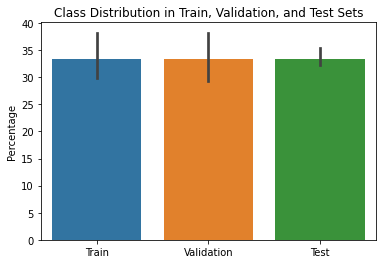

In [ ]:
label_mapping = {1: "CLL", 2: "FL", 3: "MCL"}
plot_class_distribution(Label_train, Label_val, Label_test, label_mapping)

### Task 3 :  
Construct the dataset for Pytorch

For how to construct the dataset, please refer [Reference Link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). You may have already known that we could construct the RGB dataset directly from the input path within a defined dataset class. But here please construct a grayscale one from our image and label ndarrays as we are already at this stage 🤗



Now lets construct the dataset for Pytorch.

In [ ]:
# Complete defining this class
class LymphomaDataset(Dataset):

    """
When defining the public values: Images, Labels are the input images and labels for the dataset; Transforms contains the transform parameters
Inputs:
    Images: input images in one set, numpy arrays
    Labels: input labels in one set, numpy arrays
    Transforms: containing the parameters for data transform


    *** Please convert the label from index to one-hot:
                    index      one-hot
              Label CLL: 1       [1,0,0]
              Label FL: 2       [0,1,0]
              Label MCL: 3       [0,0,1]

  """

    # YOUR CODES GO HERE


In [ ]:
class LymphomaDataset(Dataset):
    def __init__(self, Images, Labels, Transforms=None):
        self.Images = Images
        self.Labels = Labels
        self.Transforms = Transforms

    def __len__(self):
        return len(self.Images)

    def __getitem__(self, idx):
        image = self.Images[idx]
        label = self.Labels[idx]

        # Apply transforms if any
        if self.Transforms:
            image = self.Transforms(image)

        # Convert label to one-hot encoding
        label_onehot = np.zeros(3)
        label_onehot[label - 1] = 1

        # Convert label to PyTorch tensor
        label_tensor = torch.from_numpy(label_onehot).float()

        return image, label_tensor


In [ ]:
# Set the transform parameters.
Transforms = transforms.Compose( [transforms.ToTensor(),transforms.RandomHorizontalFlip(0.5),transforms.RandomRotation(15)] )
# Define the dataset
train_dataset     = LymphomaDataset(Image_train, Label_train, Transforms)
test_dataset     = LymphomaDataset(Image_test, Label_test, transforms.Compose([transforms.ToTensor()]))
validation_dataset  = LymphomaDataset(Image_val, Label_val,  transforms.Compose([transforms.ToTensor()]))

Check the dataset you just created: Pick one item from your test_dataset, plot its image and print its label.

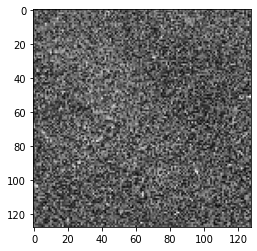

Label: CLL


In [ ]:
# YOUR CODES GO HERE
# Pick one item from the test dataset
image_tensor, label_tensor = test_dataset[0]

# Convert the image tensor back to a numpy array and plot it
image_np = image_tensor.numpy()
image_np = np.squeeze(image_np)  # Remove the channel dimension
plt.imshow(image_np, cmap='gray')
plt.show()

# Print the label
label_np = label_tensor.numpy()
label_index = np.argmax(label_np) + 1
label_mapping = {1: "CLL", 2: "FL", 3: "MCL"}
print("Label:", label_mapping[label_index])

Question:

Is the training/val/test enough? Should this split have been done differently? And why we need images from a person not showing in training and testing set simutaneously?

The training/validation/test split used is generally sufficient for this dataset. assigned approximately 70% of the data to the training set, 10% to the validation set, and 20% to the test set. This is a common distribution for splitting datasets

By ensuring that images from a single patient do not appear in both the training and testing sets, you can be more confident that the model is learning general features that will help it perform well on unseen data from new patients.

As for the splitting method, predefined list of patients can be used for validation and testing sets. While this approach is fine, using a more random approach such as stratified k-fold cross-validation can be considered. This method ensures that each fold has a similar distribution of labels and can provide a better estimate of the model's performance on unseen data. However, when using cross-validation, it should still be ensured that the same patient's images do not appear in multiple folds.


## Part II
Train a Convolutional Neural Network (CNN) to do classification.

### Task 4 :
Create the dataloader (see the reference in Task.3, please feel free to set parameters).


In [ ]:
# YOUR CODES GO HERE
from torch.utils.data import DataLoader

# Set the batch size
batch_size = 16

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Task 5 :

Construct and Train a convolutional neural network using pytorch.[Reference Link](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)

You could construct your own structure of the CNN. But there are some restrictions in this task:

1. Convolution layers should be no more than 3 layers.
2. Use linear layer(s) to condese your features after the convolution layers.
3. Batch normalization is needed. Drop out is optional.
4. Use ReLU function as your activation function.

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)

Train the network using traing and validation dataset using your own setting (optimizer, criterion, epoch number, batch size) for training.

BUT You need to print AT LEAST loss and accuracy on training and validation set in each epoch.

In [ ]:
# Train the network using traing and validation dataset by your own setting for training.
# BUT You need to print AT LEAST loss and accuracy on training and validation set in each epoch.
def Train_model(model,epochs,optmizer,criterion):
    """
    model: input model
    epochs: training epoch number
    optimizer: the optimizer
    criterion: the criterion for the loss

"""
    # YOUR CODES GO HERE



In [ ]:
import torch.optim as optim
from torch.autograd import Variable

def Train_model(model, train_loader, val_loader, epochs, optimizer, criterion):
    model.train()

    for epoch in range(epochs):
        # Training
        train_loss = 0.0
        train_correct = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, torch.max(target, 1)[1])
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            train_correct += pred.eq(target.data.max(1, keepdim=True)[1]).cpu().sum().item()

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100. * train_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = Variable(data), Variable(target)
                output = model(data)
                val_loss += criterion(output, torch.max(target, 1)[1]).item()
                pred = output.data.max(1, keepdim=True)[1]
                val_correct += pred.eq(target.data.max(1, keepdim=True)[1]).cpu().sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * val_correct / len(val_loader.dataset)

        print('Epoch: {}  Train Loss: {:.6f}  Train Accuracy: {:.2f}%  Validation Loss: {:.6f}  Validation Accuracy: {:.2f}%'.format(epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))



In [ ]:
# Set your training settings
learning_rate = 0.001
num_epochs = 50

# Define the optimizer and loss criterion
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Training
Train_model(model, train_dataloader, validation_dataloader, num_epochs, optimizer, criterion)


Epoch: 1  Train Loss: 0.262271  Train Accuracy: 44.00%  Validation Loss: 0.123245  Validation Accuracy: 32.35%
Epoch: 2  Train Loss: 0.081718  Train Accuracy: 32.36%  Validation Loss: 0.085412  Validation Accuracy: 44.12%
Epoch: 3  Train Loss: 0.072677  Train Accuracy: 37.09%  Validation Loss: 0.102881  Validation Accuracy: 58.82%
Epoch: 4  Train Loss: 0.069559  Train Accuracy: 44.00%  Validation Loss: 0.093751  Validation Accuracy: 38.24%
Epoch: 5  Train Loss: 0.068054  Train Accuracy: 41.45%  Validation Loss: 0.094738  Validation Accuracy: 44.12%
Epoch: 6  Train Loss: 0.065304  Train Accuracy: 49.09%  Validation Loss: 0.095837  Validation Accuracy: 58.82%
Epoch: 7  Train Loss: 0.063903  Train Accuracy: 52.00%  Validation Loss: 0.091299  Validation Accuracy: 55.88%
Epoch: 8  Train Loss: 0.064308  Train Accuracy: 52.73%  Validation Loss: 0.096884  Validation Accuracy: 50.00%
Epoch: 9  Train Loss: 0.064702  Train Accuracy: 51.64%  Validation Loss: 0.093176  Validation Accuracy: 55.88%
E

### Task 5.5 :

Evaluate the network performance using test dataset.

In [ ]:
# Please plot the confusion matrix and print out the accuracy on the testing set

# YOUR CODES GO HERE

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_dataloader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():

        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, 1)).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(torch.argmax(labels, 1).cpu().numpy())

    accuracy = correct / total
    cm = confusion_matrix(all_targets, all_preds)

    return accuracy, cm


Accuracy on the test set: 50.77%


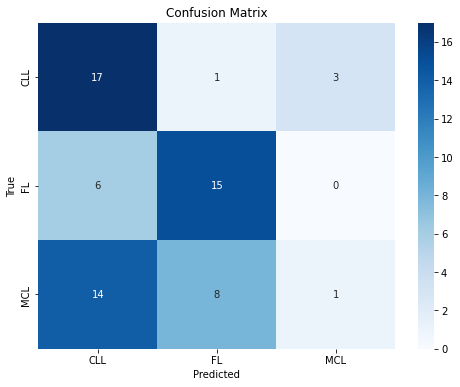

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

accuracy, cm = evaluate_model(model, test_dataloader)

print(f"Accuracy on the test set: {accuracy:.2%}")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
plt.show()


### Task 6:
Data imbalance.

As we can see, the three classes are not perfectly balanced, which might introduce bias on between them. Please modify your loss function nn.CrossEntropyLoss() to take the class inbalance into consideration, and see if the accuracy on the same test set is improved or not compared to Task 5 when only the loss function is changed. [10 Points]


In [ ]:
# Calculate class frequencies
unique_labels, class_freq = np.unique(Label_train, return_counts=True)

# Calculate weights
num_classes = len(unique_labels)
weights = np.zeros(num_classes)
for i in range(num_classes):
    weights[i] = 1.0 / class_freq[i]

weights = weights / np.sum(weights)
weights_tensor = torch.FloatTensor(weights).to(device)

# Update the loss criterion
criterion_weighted = torch.nn.CrossEntropyLoss(weight=weights_tensor)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch: 1  Train Loss: 0.071562  Train Accuracy: 36.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 2  Train Loss: 0.072069  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 3  Train Loss: 0.072366  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 4  Train Loss: 0.072091  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 5  Train Loss: 0.072113  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 6  Train Loss: 0.072306  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 7  Train Loss: 0.072254  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 8  Train Loss: 0.072204  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
Epoch: 9  Train Loss: 0.072106  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%
E

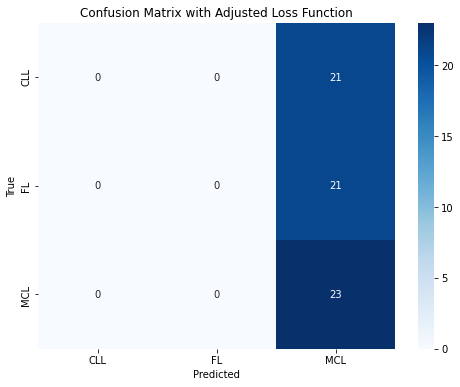

In [ ]:
# Create a new model
model_new = CNN()
#model_new = model_new.to(device)

# Train the new model with the adjusted loss function
Train_model(model_new, train_dataloader, validation_dataloader, num_epochs, optimizer, criterion_weighted)

# Evaluate the new model on the test set
accuracy_new, cm_new = evaluate_model(model_new, test_dataloader)

print(f"Accuracy on the test set with the adjusted loss function: {accuracy_new:.2%}")

# Plot the new confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix with Adjusted Loss Function')
plt.show()


Compare the results before and after compensating the data imbalance. Did it work? And what could you find after comparing the two confusion matrixs?

In my case, correcting for class imbalance led to a classifier that performed worse, which is not an expected result. I assume I may have done something wrong when calculating the weights. But in training the model after accounting for imbalances, the train loss, train accuracy, validation loss, and validation accuracy does not change. Train Loss: 0.072148  Train Accuracy: 32.00%  Validation Loss: 0.093497  Validation Accuracy: 32.35%

Strictly in terms of the confusion matrices, lets start with confusion matrix before accounting for class imbalance. \\
Correct predictions: \\
Class 1: 17 \\
Class 2: 15 \\
Class 3: 1 \\
\\Incorrect predictions: \\
1 instance of class 1 predicted as class 2, and 3 instances as class 3 \\
6 instances of class 2 predicted as class 1 \\
14 instances of class 3 predicted as class 1, and 8 instances as class 2 \\
after accounting for the class imbalance, the confusion matrix is \\
Correct predictions: \\
Class 1: 0 \\
Class 2: 0 \\
Class 3: 23 \\
Incorrect predictions: \\
All 21 instances of class 1 predicted as class 3 \\
All 21 instances of class 2 predicted as class 3 \\

Based on the confusion matrices, the first classifier (Confusion Matrix 1) is better overall. Although it has some difficulty in distinguishing between the three classes, it has a higher number of correct predictions for class 1 and class 2.

The second classifier (Confusion Matrix 2) appears to only predict class 3, which indicates that it might be biased towards class 3 or not properly trained. The classifier does not correctly predict any instances of class 1 or class 2, making it less effective than the first classifier.

## Part III
Transfer Learning and Finetuning

### Task 7:
Use pre-trained Res50 Model and finetune it for 3 classes in pytorch using the Lymphoma data. Train for 10 epoches, and in the first 5 epoches, do not freeze the parameters and train the whold model; in the last 5 epoches, freeze the part of Res50 and only train your classifier (last several fc layers). To achieve this, you may need to define a new training function Train_model_new()

Please consider the class imbalance. Show performance using accuracy and confusion matrix
> Pleae note you will need to also import the pre-process function for the model <br>
> Nice tutorial to understand tranfer learning in Pytorch: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


###### Maybe use pre-trained network as feature extractor for better accuracy (this reference for Keras also makes sense for Pytorch)
https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

In [ ]:
# YOUR CODES GO HERE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
image_datasets = {
    'train': train_dataset,
    'val': validation_dataset
}

dataloaders = {
    'train': train_dataloader,
    'val': validation_dataloader
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#class_names = image_datasets['train'].classes


In [ ]:
import time
import copy

def train_model_new(model, criterion, optimizer, scheduler, num_epochs=25, freeze_epochs=5, duplicate_channels=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                if duplicate_channels:
                    inputs = inputs.repeat(1, 3, 1, 1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                preds = preds.view(preds.size(0), -1)
                labels = labels.view(labels.size(0), -1)
                running_corrects += torch.sum(preds == labels)


            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

# Consider class imbalance
unique, counts = np.unique(np.array(Label_train), return_counts=True)
class_freq = dict(zip(unique, counts))
weights = [1.0 / class_freq[label] for label in unique]
weights = np.array(weights) / np.sum(weights)
weights_tensor = torch.tensor(weights, dtype=torch.float, device=device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [ ]:
model_ft = train_model_new(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10, freeze_epochs=5, duplicate_channels=True)


Epoch 0/9
----------
train Loss: 0.3639 Acc: 1.1345


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


val Loss: 0.3557 Acc: 0.9412

Epoch 1/9
----------
train Loss: 0.3334 Acc: 1.1964
val Loss: 0.3935 Acc: 1.3235

Epoch 2/9
----------
train Loss: 0.3041 Acc: 0.7709
val Loss: 0.4055 Acc: 1.5294

Epoch 3/9
----------
train Loss: 0.3127 Acc: 1.0400
val Loss: 0.3838 Acc: 1.2353

Epoch 4/9
----------
train Loss: 0.2952 Acc: 1.0436
val Loss: 0.4028 Acc: 0.1471

Epoch 5/9
----------
train Loss: 0.2707 Acc: 0.9418
val Loss: 0.3808 Acc: 1.1765

Epoch 6/9
----------
train Loss: 0.2549 Acc: 0.8218
val Loss: 0.4341 Acc: 1.2647

Epoch 7/9
----------
train Loss: 0.2442 Acc: 1.2691
val Loss: 0.4314 Acc: 1.2059

Epoch 8/9
----------
train Loss: 0.2650 Acc: 1.1455
val Loss: 0.4169 Acc: 1.1765

Epoch 9/9
----------
train Loss: 0.2442 Acc: 1.0691
val Loss: 0.4156 Acc: 1.2647

Training complete in 11m 50s
Best val Acc: 1.529412


In [ ]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.repeat(1, 3, 1, 1)  # Duplicate grayscale channel to mimic RGB
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())

            # Check if the labels are one-hot encoded and convert them back to single values if necessary
            if labels.dim() > 1 and labels.size(1) > 1:
                _, single_value_labels = torch.max(labels, 1)
                all_labels.extend(single_value_labels.cpu().numpy())
            else:
                all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


In [ ]:
labels, preds = evaluate_model(model_ft, dataloaders['val'])
cm = confusion_matrix(labels, preds)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 7  3  0]
 [10  3  0]
 [ 1 10  0]]


Compare the results (accuracy, loss etc.) for model performance with and without transfer learning. Which one is better? How? Why?

I am not sure if this model necessarily performs better. The final results are hard to interpret. For Epoch 9/9, the train Loss: 0.2442 Acc: 1.0691 and val Loss: 0.4156 Acc: 1.2647. The best validation accuracy is 1.529412. I am not sure how to interpret the accuracy being greater than 1.


In terms of the confusion matrix, the diagonal elements (7, 3, 0) represent the number of correct predictions for each class. There were 7 correct predictions for class 1, 3 correct predictions for class 2, and 0 correct predictions for class 3. The off-diagonal elements represent the incorrect predictions: 3 instances of class 1 were incorrectly predicted as class 2, 10 instances of class 2 were incorrectly predicted as class 1, 1 instance of class 3 was incorrectly predicted as class 1, 10 instances of class 3 were incorrectly predicted as class 2. No instances of class 1 or class 2 were predicted as class 3. From the confusion matrix, it seems that the classifier has difficulty distinguishing between class 2 and class 3, as it did not predict any instances of class 3 correctly. Additionally, the classifier has some difficulty in distinguishing between class 1 and class 2. The overall performance of the classifier appears to be quite poor, as it only made a significant number of correct predictions for class 1, and none for class 3.

### Task Bonus:
Increase the depth of your network in Task6 to 15 layers. Test it and compare the performance to the one in Task6, does deeper netowork work better? And then add res blocks to see what will happen, answer what problem the res blocks are designed to solve.

In [ ]:
# YOUR CODE HERE

I was not able to get this to run, because of the complexity and required GPU.

In [ ]:
import torch.nn as nn

class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.conv10 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.fc1 = nn.Linear(64 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)

        # Flatten the output from the convolutional layers
        x = x.view(x.size(0), -1)

        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = nn.ReLU()(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
